# Implementation of Proximal Policy Optimization on CartPole-v0
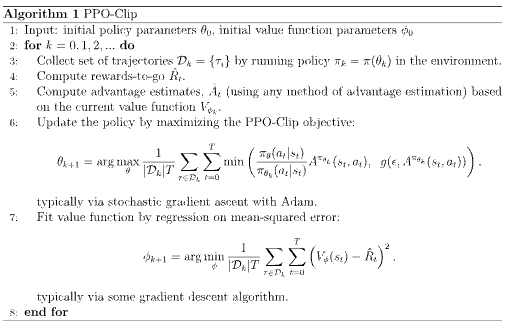
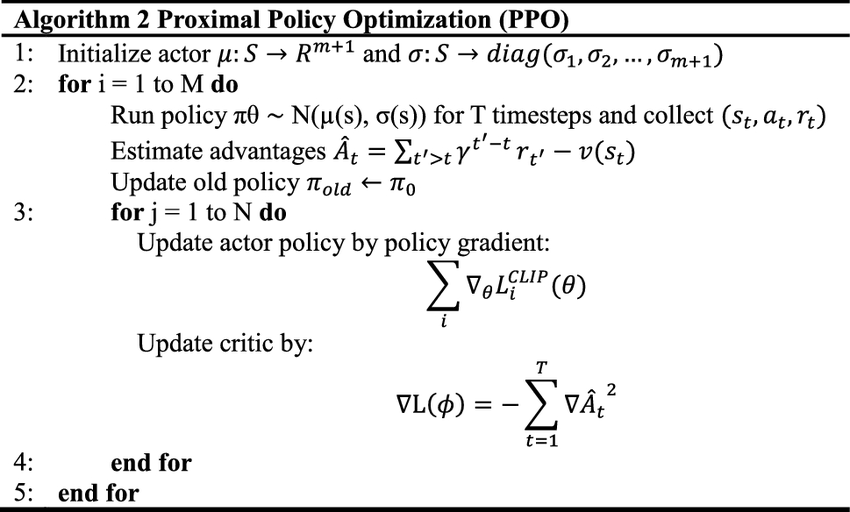

In [195]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

## Policy

In [196]:
# Initilization
trainEnv = gym.make("CartPole-v1") # Default max_time_step is 200 which should be good enough for this
testEnv = gym.make("CartPole-v1")

# Set the Seed for reproduciability
seed = 1234
trainEnv.reset(seed=seed)
testEnv.reset(seed=seed)
np.random.seed(seed)
torch.manual_seed(0)

In [197]:
# Making the Policy
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim) # Input Dim = Observation Space Dimension
        self.fc_2 = nn.Linear(hidden_dim, output_dim) # Output Layer = Action Space Dimension
        self.dropout = nn.Dropout(dropout) # TODO Prevent Overfitting? Not sure why need to investigate this more
    
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic
    
    def forward(self, state):
        actionPred = self.actor(state)
        valuePred = self.critic(state)

        return actionPred, valuePred

inputDimension = trainEnv.observation_space.shape[0]
hiddenDimension = 128 # TODO Figure out how to optimize this value
outputDimension = trainEnv.action_space.n 

actor = MLP(inputDimension, hiddenDimension, outputDimension)
critic = MLP(inputDimension, hiddenDimension, 1)

policy = ActorCritic(actor,critic)

In [198]:
# Initial Policy Theta Values
def initWeights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight) # TODO Why people use xavier weights
        m.bias.data.fill_(0)

policy.apply(initWeights)

ActorCritic(
  (actor): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [199]:
learningRate = 0.01
optimizer = optim.Adam(policy.parameters(), lr=learningRate)

In [200]:
# Helper Functions
def calculateReturns(rewards, discountFactor, normalize=True):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r+ R * discountFactor
        returns.insert(0,R)
    
    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()
    
    return returns

def calculateAdvantages(returns, values, normalize=True):
    advantages = returns - values

    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std()
    
    return advantages

def updatePolicy(policy, states, actions, probActions, advantages, returns, optimizer, ppoSteps, ppoClip):
    totalPolicyLoss = 0
    totalValueLoss = 0

    advantages = advantages.detach()
    probActions = probActions.detach()
    actions = actions.detach()

    for _ in range(ppoSteps):
        # New Probability of actions
        actionPred, valuePred = policy(states)
        valuePred = valuePred.squeeze(-1)
        actionProb = F.softmax(actionPred)
        dist = distributions.Categorical(actionProb)

        # Log new probability using old actions
        newActionProb = dist.log_prob(actions)
        policyRatio = (newActionProb - probActions).exp()

        policyLoss1 = policyRatio * advantages
        policyLoss2 = torch.clamp(policyRatio, min=1.0-ppoClip, max=1.0+ppoClip)*advantages

        policyLoss = -torch.min(policyLoss1, policyLoss2).sum()

        valueLoss = F.smooth_l1_loss(returns, valuePred).sum()

        optimizer.zero_grad()

        policyLoss.backward()
        valueLoss.backward()

        optimizer.step()

        totalPolicyLoss += policyLoss.item()
        totalValueLoss += valueLoss.item()

    return totalPolicyLoss / ppoSteps, totalValueLoss / ppoSteps
    pass

In [201]:
# Training Code
def train(env, policy, optimizer, discountFactor, ppoStep, ppoClip):
    policy.train()
    
    states = []
    actions = []
    probActions = []
    values = []
    rewards = []
    done = False
    episodeReward = 0

    state, _ = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        states.append(state)
        actionPred, valuePred = policy(state)
        actionProb = F.softmax(actionPred, dim=-1)
        dist = distributions.Categorical(actionProb)
        action = dist.sample()
        logProbAction = dist.log_prob(action)

        state, reward, done, _, _= env.step(action.item())

        actions.append(action)
        probActions.append(logProbAction)
        values.append(valuePred)
        rewards.append(reward)

        episodeReward += reward

    states = torch.cat(states)
    actions = torch.cat(actions)
    probActions = torch.cat(probActions)
    values = torch.cat(values).squeeze(-1)

    returns = calculateReturns(rewards, discountFactor)
    advantages = calculateAdvantages(returns, values)

    policyLoss, valueLoss = updatePolicy(policy, states, actions, probActions, advantages, returns, optimizer, ppoStep, ppoClip)

    return policyLoss, valueLoss, episodeReward


In [202]:
def evaluate(env, policy):
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_pred, _ = policy(state)
            action_prob = F.softmax(action_pred, dim = -1)
        action = torch.argmax(action_prob, dim = -1)  
        state, reward, done, _, _ = env.step(action.item())
        episode_reward += reward
    return episode_reward

In [203]:
# Running the training

maxEpisodes = 500
discountFactor = 0.99
nTrials = 25
rewardThreshold = 475
printEvery = 10
ppoStep = 5
ppoClip = 0.2

trainRewards = []
testRewards = []

for episode in range(1, maxEpisodes+1):
    policyLoss, valueLoss, trainReward = train(trainEnv, policy, optimizer, discountFactor, ppoStep, ppoClip)

    testReward = evaluate(testEnv, policy)

    trainRewards.append(trainReward)
    testRewards.append(testReward)

    meanTrainRewards = np.mean(trainRewards[-nTrials:])
    meanTestRewards = np.mean(testRewards[-nTrials:])

    if episode % printEvery == 0:
        print(f'| Episode: {episode:3} | Mean Train Rewards: {meanTrainRewards:5.1f} | Mean Test Rewards: {meanTestRewards:5.1f} |')
    
    if meanTestRewards >= rewardThreshold:
        print(f'Reached reward threshold in {episode} episodes')
        break
    

/var/folders/ly/khp2t7sn2pj1zr1pb5_22hp00000gn/T/ipykernel_85852/3319222283.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  actionProb = F.softmax(actionPred)


| Episode:  10 | Mean Train Rewards:  65.0 | Mean Test Rewards:  86.9 |
| Episode:  20 | Mean Train Rewards:  49.5 | Mean Test Rewards:  74.2 |
| Episode:  30 | Mean Train Rewards:  63.8 | Mean Test Rewards:  80.2 |
| Episode:  40 | Mean Train Rewards:  66.6 | Mean Test Rewards:  79.6 |
| Episode:  50 | Mean Train Rewards:  74.0 | Mean Test Rewards:  88.6 |
| Episode:  60 | Mean Train Rewards:  87.3 | Mean Test Rewards: 154.1 |
| Episode:  70 | Mean Train Rewards:  99.8 | Mean Test Rewards: 243.2 |
| Episode:  80 | Mean Train Rewards: 106.6 | Mean Test Rewards: 264.4 |
| Episode:  90 | Mean Train Rewards:  94.4 | Mean Test Rewards: 319.2 |
| Episode: 100 | Mean Train Rewards:  87.0 | Mean Test Rewards: 244.0 |
| Episode: 110 | Mean Train Rewards:  99.8 | Mean Test Rewards: 240.4 |
| Episode: 120 | Mean Train Rewards: 121.4 | Mean Test Rewards: 285.1 |
| Episode: 130 | Mean Train Rewards: 146.9 | Mean Test Rewards: 286.1 |
| Episode: 140 | Mean Train Rewards: 156.7 | Mean Test Rewards: 

[32.0, 40.0, 133.0, 60.0, 40.0, 229.0, 88.0, 42.0, 35.0, 170.0, 47.0, 27.0, 35.0, 31.0, 31.0, 31.0, 96.0, 31.0, 242.0, 44.0, 68.0, 116.0, 47.0, 108.0, 112.0, 58.0, 73.0, 75.0, 87.0, 82.0, 70.0, 48.0, 70.0, 97.0, 86.0, 48.0, 153.0, 40.0, 44.0, 65.0, 110.0, 50.0, 89.0, 296.0, 179.0, 83.0, 79.0, 127.0, 50.0, 56.0, 88.0, 138.0, 165.0, 157.0, 1305.0, 92.0, 154.0, 76.0, 69.0, 140.0, 52.0, 49.0, 50.0, 46.0, 101.0, 888.0, 414.0, 99.0, 1418.0, 184.0, 392.0, 89.0, 545.0, 235.0, 295.0, 341.0, 102.0, 309.0, 72.0, 399.0, 317.0, 938.0, 336.0, 52.0, 108.0, 73.0, 65.0, 119.0, 76.0, 114.0, 417.0, 497.0, 96.0, 721.0, 70.0, 265.0, 123.0, 113.0, 251.0, 125.0, 90.0, 145.0, 285.0, 117.0, 221.0, 687.0, 1057.0, 96.0, 104.0, 82.0, 100.0, 295.0, 366.0, 164.0, 1080.0, 177.0, 119.0, 131.0, 847.0, 88.0, 141.0, 162.0, 200.0, 127.0, 109.0, 117.0, 355.0, 232.0, 155.0, 161.0, 136.0, 114.0, 502.0, 141.0, 405.0, 221.0, 133.0, 143.0, 665.0, 533.0, 2313.0, 1888.0, 3772.0]


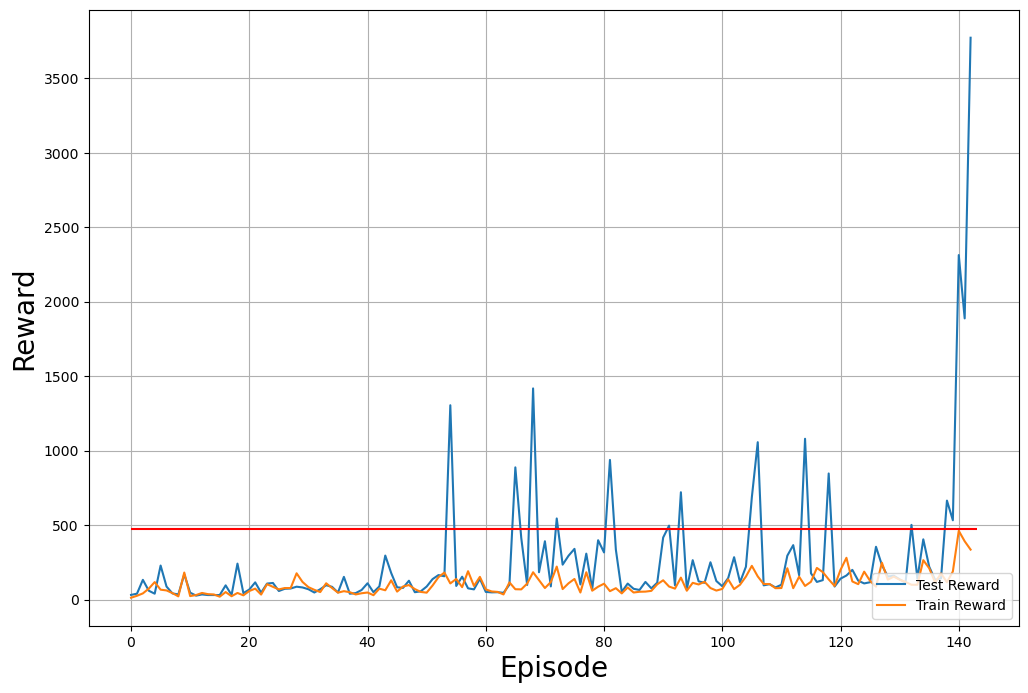

In [204]:
plt.figure(figsize=(12,8))
print(testRewards)
plt.plot(testRewards, label='Test Reward')
plt.plot(trainRewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(rewardThreshold, 0, len(testRewards), color='r')
plt.legend(loc='lower right')
plt.grid()

## Notes To Self

This is my first time utilizing PyTorch, so some the implementation of this is mainly a direct copy with some adjustments from [here](https://github.com/bentrevett/pytorch-rl/tree/master) to learn implementing algorithms on PyTorch.